Install libraries in case you don't have them installed: 
```bash
pip install polars numpy matplotlib
```

First we read our data and have them in a nice easy to use format

In [24]:
!pip install polars numpy matplotlib seaborn

In [25]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import re
from typing import Tuple, Optional, Dict
import copy
import seaborn as sns


scenarios = ['easy', 'medium', 'hard']
datasets = ['raw', 'cod', 'cot']
data = {}
data['easy'] = {}
data['medium'] = {}
data['hard'] = {}

data['easy']['raw'] = pl.read_ndjson('../data/raw/gsm8k_easy.jsonl')
data['easy']['cod'] = pl.read_ndjson('../data/training/cod_easy.jsonl')
data['easy']['cot'] = pl.read_ndjson('../data/training/cot_easy.jsonl')

data['medium']['raw'] = pl.read_ndjson('../data/raw/qwedsacf_competition_math_medium.jsonl')
data['medium']['cod'] = pl.read_ndjson('../data/training/cod_medium.jsonl')
data['medium']['cot'] = pl.read_ndjson('../data/training/cot_medium.jsonl')

data['hard']['raw'] = pl.read_ndjson('../data/raw/qwedsacf_competition_math_hard.jsonl')
data['hard']['cod'] = pl.read_ndjson('../data/training/cod_hard.jsonl')
data['hard']['cot'] = pl.read_ndjson('../data/training/cot_hard.jsonl')

Then we have a look at how it looks like

In [26]:
data['hard']['raw'].head()

problem,level,type,solution
str,str,str,str
"""What is the degree of the poly…","""Level 3""","""Algebra""","""This polynomial is not written…"
"""Evaluate $\left\lceil3\left(6-…","""Level 3""","""Algebra""","""Firstly, $3\left(6-\frac12\rig…"
"""Sam is hired for a 20-day peri…","""Level 3""","""Algebra""","""Call $x$ the number of days Sa…"
"""Find the center of the circle …","""Level 4""","""Algebra""","""Completing the square, we get …"
"""The points $(9, -5)$ and $(-3,…","""Level 3""","""Algebra""","""The center of the circle is lo…"


In [27]:
data['easy']['raw'].head()

question,answer
str,str
"""Natalia sold clips to 48 of he…","""Natalia sold 48/2 = <<48/2=24>…"
"""Weng earns $12 an hour for bab…","""Weng earns 12/60 = $<<12/60=0.…"
"""Betty is saving money for a ne…","""In the beginning, Betty has on…"
"""Julie is reading a 120-page bo…","""Maila read 12 x 2 = <<12*2=24>…"
"""James writes a 3-page letter t…","""He writes each friend 3*2=<<3*…"


First we confirm all datasets are 1000 unique samples, in the above cells we realize that the first column is always the question so we can use that information to confirm the number of unique samples.

Second, we need to confirm that for our math raw datasets we have the correct filters applied. I know that I've applied filters in the original code but there's nothing like a healthy bit of paranoia.

In [28]:
### Check for the 1000 unique samples
for scenario in scenarios:
    for dataset in datasets:
       if  data[scenario][dataset][:,0].n_unique() != 1000:
           print(f"{scenario} {dataset} has {data[scenario][dataset][:,0].n_unique()} samples")

print(f"Medium MATH has levels: {list(data['medium']['raw']['level'].unique())} and types: {list(data['medium']['raw']['type'].unique())}")

print(f"Hard MATH has levels: {list(data['hard']['raw']['level'].unique())} and types: {list(data['hard']['raw']['type'].unique())}")

Medium MATH has levels: ['Level 1', 'Level 2'] and types: ['Algebra', 'Intermediate Algebra', 'Precalculus']
Hard MATH has levels: ['Level 4', 'Level 3'] and types: ['Algebra', 'Intermediate Algebra']


We're good. Before starting the analysis of the output, let's take a look at the structure of it and the columns we have

In [29]:
columns = []
for scenario in ['easy', 'medium', 'hard']:
    for dataset in [ 'cod', 'cot']:
        columns.extend(data[scenario][dataset].columns)
set(columns)

{'id', 'input', 'instruction', 'output'}

In [30]:
data['easy']['cot'].head()

instruction,input,output,id
str,str,str,str
"""Mike can type 65 words per min…","""""","""First, determine the adjusted …","""idx_600"""
"""A cheetah can run at a top spe…","""""","""First, determine the relative …","""idx_601"""
"""A publishing house decides to …","""""","""First, identify the total amou…","""idx_602"""
"""Alyssa and Abigail need to col…","""""","""First, we identify the total n…","""idx_603"""
"""Santana has 7 brothers. 3 of t…","""""","""First, identify the months bel…","""idx_604"""


Now that we've confirmed the validity of our inputs, it's time to check validate our outputs. Mainly the following 3 points

1. The LLM gave us an answer marked by #### separator
2. The LLM gave us the steps marked by -> separator
3. The LLM gave us a correct final answer

The first 2 are relatively easy to validate, a normal string matching should be fine. However the final one as noted in the blog we need to account for variability in the results when matching with the ground truths. We therefore create the following helper functions.

In [31]:
def extract_boxed_content(text: str) -> Optional[str]:
    if not text: return None
    idx = text.rfind("\\boxed{")
    if idx == -1: return None
    start_idx = idx + 7
    balance = 1
    for i in range(start_idx, len(text)):
        char = text[i]
        if char == "{": balance += 1
        elif char == "}":
            balance -= 1
            if balance == 0: return text[start_idx:i]
    return None

def clean_competition_math_answer(text: str) -> str:
    if not text: return ""
    text = text.replace("$", "")
    text = text.replace(",", "").strip()
    return text

def extract_answer(text: str, scenario: str, is_ground_truth: bool = False) -> str:
    """
    Extracts answer based on scenario (easy=gsm8k, medium/hard=math).
    """
    if not text: return ""
    text = str(text)

    # Logic Mapping based on file names observed in your notebook
    is_math = scenario in ['medium', 'hard']
    is_gsm8k = scenario == 'easy'

    if not is_ground_truth:
        parts = text.split("####")
        if len(parts) > 1: return parts[-1].strip()
        return ""

    if is_gsm8k:
        if "####" in text: return text.split("####")[-1].strip()
        return text.strip()

    if is_math:
        boxed = extract_boxed_content(text)
        if boxed: return clean_competition_math_answer(boxed)
        if "####" in text: return text.split("####")[-1].strip()
        return text.strip()

    # Fallback
    if "####" in text: return text.split("####")[-1].strip()
    boxed = extract_boxed_content(text)
    if boxed: return boxed
    return text.strip()

def normalize_string(text: str) -> str:
    if not text: return ""
    text = str(text).strip()
    text = text.replace(",", "")
    if text.endswith("."): text = text[:-1]
    return text

def parse_number(text: str) -> Tuple[Optional[float], bool]:
    clean_text = text.replace(",", "")
    pattern = r'(-?\d+\.?\d*|-?\.\d+)(%)?'
    match = re.search(pattern, clean_text)
    if match:
        try:
            return float(match.group(1)), bool(match.group(2))
        except ValueError:
            pass
    return None, False

def check_equality(ans1: str, ans2: str) -> bool:
    s1, s2 = normalize_string(ans1), normalize_string(ans2)
    if s1 == s2: return True
    
    v1, p1 = parse_number(ans1)
    v2, p2 = parse_number(ans2)
    if v1 is None or v2 is None: return False
    
    def is_close(a, b): return abs(a - b) < 1e-6
    
    if p1 == p2: return is_close(v1, v2)
    if p1 and not p2: return is_close(v1, v2) or is_close(v1/100.0, v2)
    if p2 and not p1: return is_close(v2, v1) or is_close(v2/100.0, v1)
    return False

In [32]:
def generate_analysis_report(data_dict, scenarios, extract_fn, check_fn):
    """
    Generates summary metrics and error reports for CoT vs CoD datasets.

    Args:
        data_dict (dict): Nested dict like data[scenario]['raw'|'cot'|'cod']
        scenarios (list): List of scenario names (str) to process.
        extract_fn (callable): Function (text, scenario, is_gt) -> str
        check_fn (callable): Function (prediction, reference) -> bool

    Returns:
        tuple: (summary_df, errors_full_df, errors_extracted_df)
    """
    summary_results = []
    full_error_list = []
    extracted_error_list = []

    for scenario in scenarios:
        # Prepare Raw Data
        raw_df = data_dict[scenario]['raw']
        
        # Standardize Raw Columns
        if "problem" in raw_df.columns:
            raw_df = raw_df.rename({"problem": "question", "solution": "gt_answer"})
        elif "answer" in raw_df.columns:
            raw_df = raw_df.rename({"answer": "gt_answer"})
        
        # Clean keys for robust joining
        raw_df = raw_df.with_columns(pl.col("question").str.strip_chars())
        
        # Calculate Summary Metrics (Per Dataset)
        for ds_name in ['cot', 'cod']:
            if ds_name not in data_dict[scenario]:
                continue
                
            gen_df = data_dict[scenario][ds_name]
            
            # Prepare Gen DF (Rename + Clean Key)
            gen_prep = gen_df.rename({"instruction": "question", "output": "gen_output"})
            gen_prep = gen_prep.with_columns(pl.col("question").str.strip_chars())
            
            # Capture counts BEFORE join to detect data loss
            raw_count = raw_df.height
            
            # Join Raw and Generated
            combined = raw_df.join(gen_prep, on="question", how="inner")
            
            # Detect Join Failures
            joined_count = combined.height
            join_failures = raw_count - joined_count
            
            # Extract Answers & Check Equality
            # We use map_elements because custom python logic is required
            combined = combined.with_columns([
                pl.col("gt_answer").map_elements(
                    lambda x: extract_fn(x, scenario, True), return_dtype=pl.String
                ).alias("gt_ext"),
                pl.col("gen_output").map_elements(
                    lambda x: extract_fn(x, scenario, False), return_dtype=pl.String
                ).alias("gen_ext")
            ]).with_columns(
                pl.struct(["gen_ext", "gt_ext"]).map_elements(
                    lambda x: check_fn(x["gen_ext"], x["gt_ext"]), return_dtype=pl.Boolean
                ).alias("is_correct")
            )

            # Collect Stats
            n_answers = combined.filter(pl.col('gen_output').str.contains('####', literal=True)).height
            n_steps = combined.filter(pl.col('gen_output').str.contains('->', literal=True)).height
            n_correct = combined.filter(pl.col("is_correct")).height
            n_no_steps_incorrect = combined.filter(
                (~pl.col('gen_output').str.contains('->', literal=True)) & (~pl.col("is_correct"))
            ).height

            summary_results.append({
                "Scenario": scenario,
                "Dataset": ds_name,
                "Total Raw": raw_count,
                "Joined Count": joined_count,
                "Join Failures": join_failures,
                "Count (####)": n_answers,
                "Count (->)": n_steps,
                "Count (Correct)": n_correct,
                "No Steps & Incorrect": n_no_steps_incorrect
            })

        # Build Consolidated Error Reports (Side-by-Side)
        if 'cot' in data_dict[scenario] and 'cod' in data_dict[scenario]:
            # Prepare individual DFs
            cot = data_dict[scenario]['cot'].rename({"instruction": "question", "output": "cot_full"})
            cod = data_dict[scenario]['cod'].rename({"instruction": "question", "output": "cod_full"})
            
            # Clean keys
            cot = cot.with_columns(pl.col("question").str.strip_chars())
            cod = cod.with_columns(pl.col("question").str.strip_chars())
            
            # Join All Three (Raw + CoT + CoD)
            full_combined = raw_df.join(cot, on="question", how="inner").join(cod, on="question", how="inner")
            
            # Extract & Check
            full_combined = full_combined.with_columns([
                pl.col("gt_answer").map_elements(
                    lambda x: extract_fn(x, scenario, True), return_dtype=pl.String
                ).alias("gt_ext"),
                pl.col("cot_full").map_elements(
                    lambda x: extract_fn(x, scenario, False), return_dtype=pl.String
                ).alias("cot_ext"),
                pl.col("cod_full").map_elements(
                    lambda x: extract_fn(x, scenario, False), return_dtype=pl.String
                ).alias("cod_ext"),
            ])
            
            full_combined = full_combined.with_columns([
                pl.struct(["cot_ext", "gt_ext"]).map_elements(
                    lambda x: check_fn(x["cot_ext"], x["gt_ext"]), return_dtype=pl.Boolean
                ).alias("cot_correct"),
                pl.struct(["cod_ext", "gt_ext"]).map_elements(
                    lambda x: check_fn(x["cod_ext"], x["gt_ext"]), return_dtype=pl.Boolean
                ).alias("cod_correct"),
            ])
            
            # Filter: Keep row if EITHER model is incorrect
            errors_only = full_combined.filter((~pl.col("cot_correct")) | (~pl.col("cod_correct")))
            
            if errors_only.height > 0:
                # Report 1: Full Content
                df_full = errors_only.select([
                    pl.lit(scenario).alias("scenario"),
                    pl.col("question"),
                    pl.col("gt_answer").alias("gt_full"),
                    pl.col("cot_full"),
                    pl.col("cod_full")
                ])
                full_error_list.append(df_full)
                
                # Report 2: Extracted Content
                df_ext = errors_only.select([
                    pl.lit(scenario).alias("scenario"),
                    pl.col("question"),
                    pl.col("gt_ext"),
                    pl.col("cot_ext"),
                    pl.col("cod_ext")
                ])
                extracted_error_list.append(df_ext)

    # Final Outputs
    summary_df = pl.DataFrame(summary_results)
    errors_full_df = pl.concat(full_error_list) if full_error_list else pl.DataFrame()
    errors_extracted_df = pl.concat(extracted_error_list) if extracted_error_list else pl.DataFrame()

    return summary_df, errors_full_df, errors_extracted_df

summary_df, errors_full_df, errors_extracted_df = generate_analysis_report(data, scenarios, extract_answer, check_equality)
summary_df

Scenario,Dataset,Total Raw,Joined Count,Join Failures,Count (####),Count (->),Count (Correct),No Steps & Incorrect
str,str,i64,i64,i64,i64,i64,i64,i64
"""easy""","""cot""",1000,1000,0,1000,987,964,0
"""easy""","""cod""",1000,1000,0,1000,997,955,1
"""medium""","""cot""",1000,1000,0,1000,802,918,28
"""medium""","""cod""",1000,1000,0,997,964,923,6
"""hard""","""cot""",1000,1000,0,1000,798,896,20
"""hard""","""cod""",1000,1000,0,998,950,898,7


This is a result that brings a sad tear to my eyes. The lazy solution is to extend the limit to 1500, and rerun the generation code, this will gaurantee that we get the full correct 1000 samples, however in this analysis I'll assume this is what we have and this is what we need to fix. The second lazy solution is to resubmit with higher temperature and pray to our machine overlords it works this time, maybe with a modified prompt, but this will impact the experiment. So we have to get to cleaning.

However, we're not sure if this is the full accuracy, for a better gaurantee of the accuracy it's better to use an LLM as a judge and evaluate.

The good news is that almost all of them have answer separators and the accuracy is acceptable. The bad news is that the format for chain of thought is messed up. Gemini has failed me. Our next steps is as follows

1. Investigate chain of thought no steps format and see if we can fix them
2. Investigate incorrect answers and see if our parsers missed some formats

In [33]:
# Function to print output as we will be doing this a lot
def print_output(df, num_samples=5):
    for i, (question, answer) in enumerate(zip(df['instruction'], df['output'])):
        if i>=num_samples:
            break
        print(f"--- Sample {i+1} ---")
        print(f"Q: {question}")
        print(f"A: {answer}\n")

# Print hard output to see if there are patterns we can observe
missing_steps_df = data['hard']['cot'].filter(
    ~pl.col('output').str.contains('->', literal=True)
)

print_output(missing_steps_df)

--- Sample 1 ---
Q: What is the product of the coordinates of the midpoint of a line segment with endpoints at $(2,3)$ and $(-6,5)$?
A: To find the product of the coordinates of the midpoint, we first need to determine the coordinates of the midpoint itself.

1.  **Identify the endpoints:** The line segment has endpoints $(x_1, y_1) = (2, 3)$ and $(x_2, y_2) = (-6, 5)$.

2.  **Apply the midpoint formula:** The midpoint $M$ of a segment with endpoints $(x_1, y_1)$ and $(x_2, y_2)$ is the average of the coordinates:
    $$M = \left(\frac{x_1 + x_2}{2}, \frac{y_1 + y_2}{2}\right)$$

3.  **Calculate the x-coordinate of the midpoint:**
    Substitute $x_1 = 2$ and $x_2 = -6$:
    $$x_m = \frac{2 + (-6)}{2} = \frac{-4}{2} = -2$$

4.  **Calculate the y-coordinate of the midpoint:**
    Substitute $y_1 = 3$ and $y_2 = 5$:
    $$y_m = \frac{3 + 5}{2} = \frac{8}{2} = 4$$

    So, the midpoint is $(-2, 4)$.

5.  **Calculate the product of the coordinates:**
    Multiply the x-coordinate by the y-

The common pattern here is the two new lines, a \n\n. We can assume that this is the separator between the steps, but before we make this adjustment let's look at the medium data as well if there are new patterns

In [34]:
missing_steps_df = data['medium']['cot'].filter(
    ~pl.col('output').str.contains('->', literal=True)
)

print_output(missing_steps_df)

--- Sample 1 ---
Q: If $9s+5t=108$ and $s$ is two less than $t$, what is $t$?
A: First, identify the two equations provided in the problem statement. The first equation is $9s + 5t = 108$. The second piece of information states that "$s$ is two less than $t$," which translates to the equation $s = t - 2$.

Next, substitute the expression for $s$ into the first equation. Replacing $s$ with $(t - 2)$ in $9s + 5t = 108$ gives:
$9(t - 2) + 5t = 108$

Now, distribute the 9 across the terms inside the parentheses:
$9t - 18 + 5t = 108$

Combine the like terms involving $t$ ($9t$ and $5t$):
$14t - 18 = 108$

To isolate the term with $t$, add 18 to both sides of the equation:
$14t = 108 + 18$
$14t = 126$

Finally, divide both sides by 14 to solve for $t$:
$t = 126 / 14$
$t = 9$

#### 9

--- Sample 2 ---
Q: If $a @ b$ is defined as $a @ b$ = $3a - 3b$, what is the value of $3 @ 5$?
A: To solve for the value of $3 @ 5$, we must first understand the definition of the custom operation provided.

Th

Again, most of them follow the same case of \n\n to be a new step, however there are cases where this is an outlier. Such as the one where it wrote two methods or the one where it separates into parts and creates a numbered list for one part


For now we will just use \n\n as replace, our logic will be as follows

If arrows are not present, replace \n\n with an '-> ' unless it's the last one before the seperator

After the adjustment we have another look and evaluate the datasets

In [35]:
def clean_cot_conditional(text: str) -> str:
    if text is None:
        return ""

    # If the text already contains the arrow separator, we assume it is correct 
    # and return it as is.
    if "->" in text:
        return text
    
    # Otherwise, proceed with the cleaning logic
    
    # 1. Split into reasoning and answer
    reasoning, separator, answer = text.partition("####")
    
    if not separator:
        # No answer separator found, return as is, we will delete this later
        return text
    
    # 2. Process reasoning part
    # Replace \n\n with ' -> ' but preserve the last one if it acts as 
    # the spacer before the #### separator
    if reasoning.endswith("\n\n"):
        cleaned_reasoning = reasoning[:-2].replace("\n\n", " -> ") + "\n\n"
    else:
        cleaned_reasoning = reasoning.replace("\n\n", " -> ")

    # 3. Reassemble
    return cleaned_reasoning + separator + answer

# Keep original data
data_cleaned = copy.deepcopy(data)

target_scenarios = ['medium', 'hard']

for scenario in target_scenarios:
    print(f"Cleaning {scenario} - cot (Conditional)...")
    
    # Apply the conditional cleaning function
    data_cleaned[scenario]['cot'] = data_cleaned[scenario]['cot'].with_columns(
        pl.col('output')
        .map_elements(clean_cot_conditional, return_dtype=pl.String)
        .alias('output')
    )

# Print new summary report
summary_df_cleaned, errors_full_df_cleaned, errors_extracted_df_cleaned = generate_analysis_report(data_cleaned, scenarios, extract_answer, check_equality)
summary_df_cleaned

Cleaning medium - cot (Conditional)...
Cleaning hard - cot (Conditional)...


Scenario,Dataset,Total Raw,Joined Count,Join Failures,Count (####),Count (->),Count (Correct),No Steps & Incorrect
str,str,i64,i64,i64,i64,i64,i64,i64
"""easy""","""cot""",1000,1000,0,1000,987,964,0
"""easy""","""cod""",1000,1000,0,1000,997,955,1
"""medium""","""cot""",1000,1000,0,1000,999,918,0
"""medium""","""cod""",1000,1000,0,997,964,923,6
"""hard""","""cot""",1000,1000,0,1000,1000,896,0
"""hard""","""cod""",1000,1000,0,998,950,898,7


Again, let's print to verify it looks good

In [36]:
# Get missing arrow in original dataset
missing_arrow_mask = ~data[scenario][dataset]['output'].str.contains('->', literal=True)

# Apply  mask to cleaned data to get only the modified rows
modified_steps_df = data_cleaned[scenario][dataset]\
    .with_row_index(name="original_index")\
    .filter(missing_arrow_mask)

print_output(modified_steps_df)

--- Sample 1 ---
Q: What is the product of the coordinates of the midpoint of a line segment with endpoints at $(2,3)$ and $(-6,5)$?
A: To find the product of the coordinates of the midpoint, we first need to determine the coordinates of the midpoint itself. -> 1.  **Identify the endpoints:** The line segment has endpoints $(x_1, y_1) = (2, 3)$ and $(x_2, y_2) = (-6, 5)$. -> 2.  **Apply the midpoint formula:** The midpoint $M$ of a segment with endpoints $(x_1, y_1)$ and $(x_2, y_2)$ is the average of the coordinates:
    $$M = \left(\frac{x_1 + x_2}{2}, \frac{y_1 + y_2}{2}\right)$$ -> 3.  **Calculate the x-coordinate of the midpoint:**
    Substitute $x_1 = 2$ and $x_2 = -6$:
    $$x_m = \frac{2 + (-6)}{2} = \frac{-4}{2} = -2$$ -> 4.  **Calculate the y-coordinate of the midpoint:**
    Substitute $y_1 = 3$ and $y_2 = 5$:
    $$y_m = \frac{3 + 5}{2} = \frac{8}{2} = 4$$ ->     So, the midpoint is $(-2, 4)$. -> 5.  **Calculate the product of the coordinates:**
    Multiply the x-coordina

Let's look at a sample where the arrow exists

In [37]:
steps_df = data['medium']['cot'].filter(
    pl.col('output').str.contains('->', literal=True)
)
print_output(steps_df)

--- Sample 1 ---
Q: Point $M(4,4)$ is the midpoint of $\overline{AB}$. If point $A$ has coordinates $(8,4)$, what is the sum of the coordinates of point $B$?
A: We are given the midpoint $M(4,4)$ and one endpoint $A(8,4)$, and we need to find the coordinates of the other endpoint $B(x,y)$ to calculate their sum -> Using the midpoint formula, the x-coordinate of the midpoint is the average of the endpoints' x-coordinates: $\frac{8+x}{2} = 4$, which implies $8+x=8$, so $x=0$ -> Similarly, for the y-coordinate: $\frac{4+y}{2} = 4$, which implies $4+y=8$, so $y=4$ -> The coordinates of point $B$ are $(0,4)$, and the sum of these coordinates is $0+4=4$. #### 4

--- Sample 2 ---
Q: What is $\sqrt[4]{81} \cdot \sqrt[3]{27} \cdot \sqrt{9}$ expressed as a positive integer?
A: First, evaluate each radical term individually to simplify the expression -> The fourth root of 81 is 3, because $3^4 = 81$ -> The cube root of 27 is 3, because $3^3 = 27$ -> The square root of 9 is 3, because $3^2 = 9$ ->

They look similar enough. Now that we've fixed the issue with the missing arrows let's tackle the issue of incorrect answers. Previously we've generated in our report a errors_extracted_df that we can use to analyze the mistakes and see what went wrong

In [38]:
rows_list = errors_full_df_cleaned.filter(
    pl.col('scenario') == 'medium'
).tail(5).to_dicts()

# Print them out nicely
for i, row in enumerate(rows_list):
    print(f"--- Row {i} ---")
    print(row)

--- Row 0 ---
{'scenario': 'medium', 'question': 'Find all roots of the polynomial $x^3-5x^2+3x+9$. Enter your answer as a list of numbers separated by commas. If a root occurs more than once, enter it as many times as its multiplicity.', 'gt_full': 'By the Rational Root Theorem, any root of the polynomial must divide $9$. Therefore the roots are among the numbers $\\pm 1,3$. Since these are only four values, we can try all of them to find that $x=3$ and $x=-1$ are roots and $x=-3$ and $x=1$ are not.\n\nSince the given polynomial is cubic, it must have three roots. This means that one of $3$ or $-1$ is a root twice (i.e. has multiplicity $2$). The Factor Theorem tells us that since $-1$ and $3$ are roots of the polynomial, $x+1$ and $x-3$ must be factors of the polynomial. To find which root occurs twice, we can divide $x^3-5x^2+3x+9$ by $x+1$ to get  $x^3-5x^2+3x+9 = (x+1)(x^2-6x+9)$.\n\nWe can factorise $x^2-6x+9$ as $(x-3)^2$ which means that the root $x=3$ has multiplicity 2.  Thus

In [39]:
rows_list = errors_extracted_df_cleaned.filter(
    pl.col('scenario') == 'medium'
).tail(5).to_dicts()

# Print them out nicely
for i, row in enumerate(rows_list):
    print(f"--- Row {i} ---")
    print(row)

--- Row 0 ---
{'scenario': 'medium', 'question': 'Find all roots of the polynomial $x^3-5x^2+3x+9$. Enter your answer as a list of numbers separated by commas. If a root occurs more than once, enter it as many times as its multiplicity.', 'gt_ext': '-133', 'cot_ext': '-1, 3, 3', 'cod_ext': '-1, 3, 3'}
--- Row 1 ---
{'scenario': 'medium', 'question': 'Which type of conic section is described by the equation \\[|y+5| = \\sqrt{(x-2)^2 + y^2}?\\]Enter "C" for circle, "P" for parabola, "E" for ellipse, "H" for hyperbola, and "N" for none of the above.', 'gt_ext': '\\text{(P)}', 'cot_ext': 'P', 'cod_ext': 'P'}
--- Row 2 ---
{'scenario': 'medium', 'question': 'The hyperbola given by the equation \\[\\frac{y^2}{9}-\\frac{x^2}{4} = 1\\]has asymptotes $y = \\pm mx,$ where $m$ is positive. Find $m.$', 'gt_ext': '\\frac32', 'cot_ext': '\\frac{3}{2}', 'cod_ext': '\\frac{3}{2}'}
--- Row 3 ---
{'scenario': 'medium', 'question': 'When a polynomial is divided by $2x^2 - 7x + 18,$ what are the possible 

Looking at answers in our datasets, we notice some main descrepancies:

1. Fractions in latex such as \\frac{1}{2} are not getting parsed correctly, so we decided to resolve fractions.
2. Cases with \\text{P} are also not getting parsed correct, so we decided to resolve latex

We therefore update our extract functions to resolve these issues.

In [40]:
def resolve_fractions(text: str) -> str:
    """
    Resolves both LaTeX fractions (\\frac{1}{2}) AND plain text fractions (1/2) to decimals.
    Examples: 
      "\\frac{1}{2}" -> "0.5"
      "1/2"          -> "0.5"
      "1,000/4"      -> "250.0"
    """
    if not text: return text
    text = str(text)
    
    # --- Helper: Perform Division ---
    def calculate_div(n_str, d_str):
        try:
            n = float(n_str.replace(',', '').strip())
            d = float(d_str.replace(',', '').strip())
            if d == 0: return None
            return str(n / d)
        except ValueError:
            return None

    # --- Pass 1: LaTeX Fractions (\frac{a}{b}) ---
    def repl_latex(m):
        val = calculate_div(m.group(2), m.group(3))
        return val if val is not None else m.group(0)

    # Pattern matches \frac{...}{...} or \dfrac{...}{...}
    text = re.sub(r'\\(d?)frac\{([^{}]+)\}\{([^{}]+)\}', repl_latex, text)

    # --- Pass 2: Plain Text Fractions (a/b) ---
    def repl_plain(m):
        val = calculate_div(m.group(1), m.group(2))
        return val if val is not None else m.group(0)

    # Pattern matches: number / number
    # Handles negatives (-1/2) and commas (1,000/2)
    # We use a lookahead (?!\d) to ensure we don't cut off numbers, though straightforward matching works well here.
    plain_pattern = r'(-?\d+(?:,\d+)*)\s*/\s*(-?\d+(?:,\d+)*)'
    text = re.sub(plain_pattern, repl_plain, text)

    return text

def extract_boxed_content(text: str) -> Optional[str]:
    if not text: return None
    idx = text.rfind("\\boxed{")
    if idx == -1: return None
    start_idx = idx + 7
    balance = 1
    for i in range(start_idx, len(text)):
        char = text[i]
        if char == "{": balance += 1
        elif char == "}":
            balance -= 1
            if balance == 0: return text[start_idx:i]
    return None

def clean_competition_math_answer(text: str) -> str:
    if not text: return ""
    text = text.replace("$", "")
    text = text.replace(",", "").strip()
    return text

def extract_answer(text: str, scenario: str, is_ground_truth: bool = False) -> str:
    """
    Extracts answer based on scenario (easy=gsm8k, medium/hard=math).
    """
    if not text: return ""
    text = str(text)

    # --- ADDED: Fraction Resolution ---
    # We apply this globally first so \boxed{\frac{1}{2}} becomes \boxed{0.5}
    text = resolve_fractions(text)
    # ----------------------------------

    # Logic Mapping based on file names observed in your notebook
    is_math = scenario in ['medium', 'hard']
    is_gsm8k = scenario == 'easy'

    if not is_ground_truth:
        parts = text.split("####")
        if len(parts) > 1: return parts[-1].strip()
        return ""

    if is_gsm8k:
        if "####" in text: return text.split("####")[-1].strip()
        return text.strip()

    if is_math:
        boxed = extract_boxed_content(text)
        if boxed: return clean_competition_math_answer(boxed)
        if "####" in text: return text.split("####")[-1].strip()
        return text.strip()

    # Fallback
    if "####" in text: return text.split("####")[-1].strip()
    boxed = extract_boxed_content(text)
    if boxed: return boxed
    return text.strip()

def normalize_string(text: str) -> str:
    if not text: return ""
    text = str(text).strip()
    text = text.replace(",", "")
    if text.endswith("."): text = text[:-1]
    return text

def parse_number(text: str) -> Tuple[Optional[float], bool]:
    clean_text = text.replace(",", "")
    pattern = r'(-?\d+\.?\d*|-?\.\d+)(%)?'
    match = re.search(pattern, clean_text)
    if match:
        try:
            return float(match.group(1)), bool(match.group(2))
        except ValueError:
            pass
    return None, False

def check_equality(ans1: str, ans2: str) -> bool:
    s1, s2 = normalize_string(ans1), normalize_string(ans2)
    if s1 == s2: return True
    
    v1, p1 = parse_number(ans1)
    v2, p2 = parse_number(ans2)
    if v1 is None or v2 is None: return False
    
    def is_close(a, b): return abs(a - b) < 1e-6
    
    if p1 == p2: return is_close(v1, v2)
    if p1 and not p2: return is_close(v1, v2) or is_close(v1/100.0, v2)
    if p2 and not p1: return is_close(v2, v1) or is_close(v2/100.0, v1)
    return False

In [41]:
# Print new summary report
summary_df_cleaned, errors_full_df_cleaned, errors_extracted_df_cleaned = generate_analysis_report(data_cleaned, scenarios, extract_answer, check_equality)
summary_df_cleaned

Scenario,Dataset,Total Raw,Joined Count,Join Failures,Count (####),Count (->),Count (Correct),No Steps & Incorrect
str,str,i64,i64,i64,i64,i64,i64,i64
"""easy""","""cot""",1000,1000,0,1000,987,964,0
"""easy""","""cod""",1000,1000,0,1000,997,955,1
"""medium""","""cot""",1000,1000,0,1000,999,933,0
"""medium""","""cod""",1000,1000,0,997,964,932,6
"""hard""","""cot""",1000,1000,0,1000,1000,935,0
"""hard""","""cod""",1000,1000,0,998,950,932,8


Another sad tear to my eye. Despite the implementation of a better resolution algorithm the accuracy has decreased. This only means that our original resolution algorithm was giving false positives. There is more that can be done here but I'll stop at this for now.

If you want, you can pass this to an LLM as a judge for evaluation and get the actual accuracy. For now we'll resolve with this. Do the analysis and write the report.

In [42]:
def match_datasets(data_cleaned):
    """
    Balances 'cot' and 'cod' datasets for each scenario:
    1. Identifies the smaller dataset.
    2. Slices the larger dataset to match the size.
    3. PRIORITIZES keeping samples that DO exist in the smaller dataset (Intersection).
    """
    print(f"\n⚖️  Dataset Matching Report (Prioritizing Overlap)")
    print("=" * 70)
    print(f"{'Scenario':<10} | {'Small':<5} | {'Large':<5} | {'Overlap Kept':<12} | {'Unique Kept':<12} | {'Final Size'}")
    print("-" * 70)

    for scenario, splits in data_cleaned.items():
        if 'cot' not in splits or 'cod' not in splits:
            continue
            
        df_cot = splits['cot']
        df_cod = splits['cod']
        
        n_cot = df_cot.height
        n_cod = df_cod.height
        
        if n_cot == n_cod:
            print(f"{scenario:<10} | {'--':<5} | {'--':<5} | {'--':<12} | {'--':<12} | {n_cot}")
            continue

        # 1. Identify Smaller vs Larger
        if n_cot < n_cod:
            small_key, big_key = 'cot', 'cod'
            df_small, df_big = df_cot, df_cod
            target_n = n_cot
        else:
            small_key, big_key = 'cod', 'cot'
            df_small, df_big = df_cod, df_cot
            target_n = n_cod

        # 2. Identify Overlap
        # Fix: Convert to list to avoid Polars deprecation warning/ambiguity
        small_instr_list = df_small["instruction"].to_list()
        
        df_big = df_big.with_columns(
            is_overlap = pl.col("instruction").is_in(small_instr_list)
        )

        # 3. Sort by Overlap (Descending: True first) -> Intersection First
        df_big_sorted = df_big.sort("is_overlap", descending=True)
        
        # 4. Slice to Target Size
        df_big_sliced = df_big_sorted.head(target_n)
        
        # Stats
        n_overlap_kept = df_big_sliced.filter(pl.col("is_overlap")).height
        n_unique_kept = df_big_sliced.filter(~pl.col("is_overlap")).height
        
        # 5. Update Dictionary
        data_cleaned[scenario][big_key] = df_big_sliced.drop("is_overlap")
        
        print(f"{scenario:<10} | {small_key:<5} | {big_key:<5} | {n_overlap_kept:<12} | {n_unique_kept:<12} | {target_n}")

    print("=" * 70)
    return data_cleaned

def clean_and_struct_data(data_dict, scenarios, extract_fn, check_fn):
    """
    Cleans the datasets: Must have '->' AND be correct.
    
    Returns: 
        data_cleaned (dict): Same structure as input but filtered.
        final_counts (dict): {scenario: {'cod': int, 'cot': int}} for analysis.
    """
    data_cleaned = {s: {} for s in scenarios}
    final_counts = {s: {} for s in scenarios}
    
    print(f"{'Scenario':<10} | {'Type':<5} | {'Raw':<6} | {'Cleaned':<8} | {'Retention'}")
    print("-" * 55)

    for scenario in scenarios:
        # 1. Prepare Raw (Ground Truth)
        raw_df = data_dict[scenario]['raw']
        
        # Standardize Raw Columns
        if "problem" in raw_df.columns:
            raw_df = raw_df.rename({"problem": "question", "solution": "gt_answer"})
        elif "answer" in raw_df.columns:
            raw_df = raw_df.rename({"answer": "gt_answer"})
            
        raw_df = raw_df.with_columns(pl.col("question").str.strip_chars())
        
        # Copy Raw to Cleaned (Unchanged)
        data_cleaned[scenario]['raw'] = raw_df

        # 2. Process CoT and CoD
        for ds_type in ['cot', 'cod']:
            if ds_type not in data_dict[scenario]:
                continue
                
            gen_df = data_dict[scenario][ds_type]
            
            # Standardize Gen Columns
            gen_df = gen_df.rename({"instruction": "question", "output": "gen_output"})
            gen_df = gen_df.with_columns(pl.col("question").str.strip_chars())
            
            # Join with Raw to get GT
            combined = raw_df.join(gen_df, on="question", how="inner")
            
            # Extract and Check Correctness
            combined = combined.with_columns([
                pl.col("gt_answer").map_elements(
                    lambda x: extract_fn(x, scenario, True), return_dtype=pl.String
                ).alias("gt_ext"),
                pl.col("gen_output").map_elements(
                    lambda x: extract_fn(x, scenario, False), return_dtype=pl.String
                ).alias("gen_ext")
            ]).with_columns(
                pl.struct(["gen_ext", "gt_ext"]).map_elements(
                    lambda x: check_fn(x["gen_ext"], x["gt_ext"]), return_dtype=pl.Boolean
                ).alias("is_correct")
            )
            
            # --- FILTERING LOGIC ---
            filtered = combined.filter(
                pl.col("gen_output").str.contains("->", literal=True) & 
                pl.col("is_correct")
            )
            
            # Restore original column names for training compatibility
            final_df = filtered.select([
                pl.col("question").alias("instruction"),
                pl.col("gen_output").alias("output")
            ])
            
            data_cleaned[scenario][ds_type] = final_df
            final_counts[scenario][ds_type] = final_df.height
            
            print(f"{scenario:<10} | {ds_type:<5} | {gen_df.height:<6} | {final_df.height:<8} | {final_df.height/gen_df.height:.1%}")

    return data_cleaned, final_counts

In [46]:
# 1. Clean Data
data_cleaned_base, cleaning_stats = clean_and_struct_data(
    data_cleaned, 
    scenarios, 
    extract_answer, 
    check_equality
)

# 1. Match datasets (now warning-free)
data_final = match_datasets(data_cleaned_base)

Scenario   | Type  | Raw    | Cleaned  | Retention
-------------------------------------------------------
easy       | cot   | 1000   | 951      | 95.1%
easy       | cod   | 1000   | 953      | 95.3%
medium     | cot   | 1000   | 932      | 93.2%
medium     | cod   | 1000   | 902      | 90.2%
hard       | cot   | 1000   | 935      | 93.5%
hard       | cod   | 1000   | 890      | 89.0%

⚖️  Dataset Matching Report (Prioritizing Overlap)
Scenario   | Small | Large | Overlap Kept | Unique Kept  | Final Size
----------------------------------------------------------------------
easy       | cot   | cod   | 940          | 11           | 951
medium     | cod   | cot   | 899          | 3            | 902
hard       | cod   | cot   | 888          | 2            | 890


In [56]:
scenarios

['easy', 'medium', 'hard']

In [60]:
import json
import os

output_dir = '../data/processed'
for scenario in scenarios:
    for dataset in ['cot','cod']:
        output_path = os.path.join(output_dir, f'{dataset}_{scenario}.jsonl')
        print(f"Processing {dataset} for {scenario} to {output_path}")
        print(f"Size of file {len(data_final[scenario][dataset])}")
        data_final[scenario][dataset].write_ndjson(output_path)

Processing cot for easy to ../data/processed\cot_easy.jsonl
Size of file 951
Processing cod for easy to ../data/processed\cod_easy.jsonl
Size of file 951
Processing cot for medium to ../data/processed\cot_medium.jsonl
Size of file 902
Processing cod for medium to ../data/processed\cod_medium.jsonl
Size of file 902
Processing cot for hard to ../data/processed\cot_hard.jsonl
Size of file 890
Processing cod for hard to ../data/processed\cod_hard.jsonl
Size of file 890


In [47]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def count_tokens_approximate(text: str) -> int:
    """
    Approximate token count using whitespace splitting.
    More accurate: use a tokenizer, but this is fast and good enough.
    For Qwen models, ~1.3-1.5 tokens per word is typical.
    """
    words = len(text.split())
    return int(words * 1.35)  # Empirical multiplier for English text

def extract_reasoning_only(text: str) -> str:
    """Extract only the reasoning part (before ####)."""
    if '####' in text:
        return text.split('####')[0].strip()
    return text.strip()

def count_steps(text: str) -> int:
    """Count reasoning steps using -> separator."""
    return text.count('->') + 1 if '->' in text else 0

def compute_metrics(dataset: pl.DataFrame, dataset_type: str) -> dict:
    """
    Compute comprehensive metrics for a dataset using Polars.
    
    Args:
        dataset: Polars DataFrame with 'output' column
        dataset_type: 'cot' or 'cod'
    
    Returns:
        Dictionary of computed metrics
    """
    # Use Polars expressions for vectorized operations
    df_metrics = dataset.select([
        pl.col('output').alias('original'),
        # Extract reasoning part
        pl.col('output').map_elements(
            extract_reasoning_only, return_dtype=pl.String
        ).alias('reasoning'),
    ]).with_columns([
        # Compute all metrics using Polars expressions
        pl.col('reasoning').str.len_chars().alias('char_count'),
        pl.col('original').str.len_chars().alias('total_length'),
        pl.col('reasoning').map_elements(
            count_tokens_approximate, return_dtype=pl.Int32
        ).alias('token_count'),
        pl.col('reasoning').map_elements(
            count_steps, return_dtype=pl.Int32
        ).alias('step_count'),
    ])
    
    metrics = {
        'type': dataset_type,
        'n_samples': dataset.height,
        # Get lists for distribution plots
        'reasoning_lengths': df_metrics['char_count'].to_list(),
        'total_lengths': df_metrics['total_length'].to_list(),
        'token_counts': df_metrics['token_count'].to_list(),
        'step_counts': df_metrics['step_count'].to_list(),
        'char_counts': df_metrics['char_count'].to_list(),
    }
    
    # Compute summary statistics using Polars aggregations
    stats = df_metrics.select([
        pl.col('token_count').mean().alias('avg_tokens'),
        pl.col('token_count').std().alias('std_tokens'),
        pl.col('step_count').mean().alias('avg_steps'),
        pl.col('step_count').std().alias('std_steps'),
        pl.col('char_count').mean().alias('avg_chars'),
        pl.col('char_count').std().alias('std_chars'),
    ]).to_dicts()[0]  # Get single row as dict
    
    metrics.update(stats)
    
    return metrics

# Compute metrics for all scenarios
print("Computing metrics across all scenarios...")
all_metrics = {}

for scenario in scenarios:
    print(f"\n{'='*60}")
    print(f"Processing: {scenario.upper()}")
    print('='*60)
    
    all_metrics[scenario] = {}
    
    for dataset_type in ['cot', 'cod']:
        if dataset_type not in data_cleaned[scenario]:
            continue
            
        print(f"\n  Analyzing {dataset_type.upper()}...")
        metrics = compute_metrics(data_cleaned[scenario][dataset_type], dataset_type)
        all_metrics[scenario][dataset_type] = metrics
        
        # Print summary
        print(f"    Samples: {metrics['n_samples']}")
        print(f"    Avg Tokens: {metrics['avg_tokens']:.1f} ± {metrics['std_tokens']:.1f}")
        print(f"    Avg Steps: {metrics['avg_steps']:.1f} ± {metrics['std_steps']:.1f}")
        print(f"    Avg Chars: {metrics['avg_chars']:.1f} ± {metrics['std_chars']:.1f}")

print("\n" + "="*60)
print("Metrics computation complete!")
print("="*60)

Computing metrics across all scenarios...

Processing: EASY

  Analyzing COT...
    Samples: 1000
    Avg Tokens: 113.4 ± 56.7
    Avg Steps: 3.9 ± 1.7
    Avg Chars: 457.6 ± 219.0

  Analyzing COD...
    Samples: 1000
    Avg Tokens: 55.6 ± 22.6
    Avg Steps: 5.1 ± 1.7
    Avg Chars: 180.7 ± 80.9

Processing: MEDIUM

  Analyzing COT...
    Samples: 1000
    Avg Tokens: 179.8 ± 119.4
    Avg Steps: 5.5 ± 2.5
    Avg Chars: 742.4 ± 487.3

  Analyzing COD...
    Samples: 1000
    Avg Tokens: 75.4 ± 57.4
    Avg Steps: 5.6 ± 2.4
    Avg Chars: 284.2 ± 245.1

Processing: HARD

  Analyzing COT...
    Samples: 1000
    Avg Tokens: 227.3 ± 374.1
    Avg Steps: 6.0 ± 3.0
    Avg Chars: 903.9 ± 1424.2

  Analyzing COD...
    Samples: 1000
    Avg Tokens: 100.6 ± 76.8
    Avg Steps: 6.7 ± 3.2
    Avg Chars: 364.6 ± 289.5

Metrics computation complete!


In [48]:
# ============================================================================
# VISUALIZATION 4: Comprehensive Summary Table (Polars Version)
# ============================================================================

def generate_summary_table():
    """
    Publication-ready table summarizing all key metrics using Polars.
    """
    rows = []
    
    for scenario in scenarios:
        if 'cot' not in all_metrics[scenario] or 'cod' not in all_metrics[scenario]:
            continue
            
        cot = all_metrics[scenario]['cot']
        cod = all_metrics[scenario]['cod']
        
        token_reduction = ((cot['avg_tokens'] - cod['avg_tokens']) / cot['avg_tokens']) * 100
        step_reduction = ((cot['avg_steps'] - cod['avg_steps']) / cot['avg_steps']) * 100
        char_reduction = ((cot['avg_chars'] - cod['avg_chars']) / cot['avg_chars']) * 100
        
        rows.append({
            'Scenario': scenario.capitalize(),
            'CoT Tokens': f"{cot['avg_tokens']:.1f} ± {cot['std_tokens']:.1f}",
            'CoD Tokens': f"{cod['avg_tokens']:.1f} ± {cod['std_tokens']:.1f}",
            'Token Reduction': f"{token_reduction:.1f}%",
            'CoT Steps': f"{cot['avg_steps']:.1f} ± {cot['std_steps']:.1f}",
            'CoD Steps': f"{cod['avg_steps']:.1f} ± {cod['std_steps']:.1f}",
            'Step Reduction': f"{step_reduction:.1f}%",
            'Samples': cot['n_samples']
        })
    
    # Create Polars DataFrame
    df = pl.DataFrame(rows)
    
    print("\n" + "="*100)
    print("COMPREHENSIVE METRICS SUMMARY")
    print("="*100)
    print(df)
    print("="*100)
    
    # Calculate aggregate statistics
    all_token_reductions = []
    all_step_reductions = []
    
    for scenario in scenarios:
        if 'cot' not in all_metrics[scenario] or 'cod' not in all_metrics[scenario]:
            continue
        cot = all_metrics[scenario]['cot']
        cod = all_metrics[scenario]['cod']
        all_token_reductions.append(((cot['avg_tokens'] - cod['avg_tokens']) / cot['avg_tokens']) * 100)
        all_step_reductions.append(((cot['avg_steps'] - cod['avg_steps']) / cot['avg_steps']) * 100)
    
    print(f"\n📊 AGGREGATE RESULTS:")
    print(f"   Mean Token Reduction: {np.mean(all_token_reductions):.1f}% ± {np.std(all_token_reductions):.1f}%")
    print(f"   Mean Step Reduction:  {np.mean(all_step_reductions):.1f}% ± {np.std(all_step_reductions):.1f}%")
    print(f"\n🎯 KEY INSIGHT:")
    print(f"   CoD achieves ~{np.mean(all_token_reductions):.0f}% token reduction while maintaining")
    print(f"   structural correctness - ideal for speculative decoding alignment!")
    
    return df

summary_df = generate_summary_table()


COMPREHENSIVE METRICS SUMMARY
shape: (3, 8)
┌──────────┬─────────────┬─────────────┬────────────┬───────────┬───────────┬────────────┬─────────┐
│ Scenario ┆ CoT Tokens  ┆ CoD Tokens  ┆ Token      ┆ CoT Steps ┆ CoD Steps ┆ Step       ┆ Samples │
│ ---      ┆ ---         ┆ ---         ┆ Reduction  ┆ ---       ┆ ---       ┆ Reduction  ┆ ---     │
│ str      ┆ str         ┆ str         ┆ ---        ┆ str       ┆ str       ┆ ---        ┆ i64     │
│          ┆             ┆             ┆ str        ┆           ┆           ┆ str        ┆         │
╞══════════╪═════════════╪═════════════╪════════════╪═══════════╪═══════════╪════════════╪═════════╡
│ Easy     ┆ 113.4 ±     ┆ 55.6 ± 22.6 ┆ 51.0%      ┆ 3.9 ± 1.7 ┆ 5.1 ± 1.7 ┆ -31.0%     ┆ 1000    │
│          ┆ 56.7        ┆             ┆            ┆           ┆           ┆            ┆         │
│ Medium   ┆ 179.8 ±     ┆ 75.4 ± 57.4 ┆ 58.1%      ┆ 5.5 ± 2.5 ┆ 5.6 ± 2.4 ┆ -3.1%      ┆ 1000    │
│          ┆ 119.4       ┆             ┆      

In [51]:
# ============================================================================
# UPDATED METRICS COMPUTATION WITH OUTLIER REMOVAL
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import numpy as np
from pathlib import Path

# Set style for publication-quality plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def count_tokens_approximate(text: str) -> int:
    """
    Approximate token count using whitespace splitting.
    For Qwen models, ~1.3-1.5 tokens per word is typical.
    """
    words = len(text.split())
    return int(words * 1.35)

def extract_reasoning_only(text: str) -> str:
    """Extract only the reasoning part (before ####)."""
    if '####' in text:
        return text.split('####')[0].strip()
    return text.strip()

def count_steps(text: str) -> int:
    """Count reasoning steps using -> separator."""
    return text.count('->') + 1 if '->' in text else 0

def remove_outliers_iqr(data: list) -> list:
    """
    Remove outliers using IQR method (Interquartile Range).
    Outliers are defined as values outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    
    Args:
        data: List of numerical values
    
    Returns:
        List with outliers removed
    """
    if len(data) < 4:  # Need at least 4 points for meaningful quartiles
        return data
    
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    cleaned = [x for x in data if lower_bound <= x <= upper_bound]
    
    n_outliers = len(data) - len(cleaned)
    if n_outliers > 0:
        print(f"      Removed {n_outliers} outliers ({n_outliers/len(data)*100:.1f}% of data)")
    
    return cleaned

def compute_metrics_with_quartiles(dataset: pl.DataFrame, dataset_type: str) -> dict:
    """
    Compute comprehensive metrics for a dataset using Polars.
    Uses MEDIAN and quartiles instead of mean, with outlier removal.
    
    Args:
        dataset: Polars DataFrame with 'output' column
        dataset_type: 'cot' or 'cod'
    
    Returns:
        Dictionary of computed metrics including quartiles
    """
    # Use Polars expressions for vectorized operations
    df_metrics = dataset.select([
        pl.col('output').alias('original'),
        # Extract reasoning part
        pl.col('output').map_elements(
            extract_reasoning_only, return_dtype=pl.String
        ).alias('reasoning'),
    ]).with_columns([
        # Compute all metrics using Polars expressions
        pl.col('reasoning').str.len_chars().alias('char_count'),
        pl.col('original').str.len_chars().alias('total_length'),
        pl.col('reasoning').map_elements(
            count_tokens_approximate, return_dtype=pl.Int32
        ).alias('token_count'),
        pl.col('reasoning').map_elements(
            count_steps, return_dtype=pl.Int32
        ).alias('step_count'),
    ])
    
    # Get raw lists
    token_counts_raw = df_metrics['token_count'].to_list()
    step_counts_raw = df_metrics['step_count'].to_list()
    char_counts_raw = df_metrics['char_count'].to_list()
    
    # Remove outliers
    token_counts_clean = remove_outliers_iqr(token_counts_raw)
    step_counts_clean = remove_outliers_iqr(step_counts_raw)
    char_counts_clean = remove_outliers_iqr(char_counts_raw)
    
    metrics = {
        'type': dataset_type,
        'n_samples': dataset.height,
        'n_samples_after_outlier_removal': len(token_counts_clean),
        
        # Store cleaned data for plotting
        'token_counts': token_counts_clean,
        'step_counts': step_counts_clean,
        'char_counts': char_counts_clean,
        
        # Median and quartiles for tokens
        'median_tokens': np.median(token_counts_clean),
        'q1_tokens': np.percentile(token_counts_clean, 25),
        'q3_tokens': np.percentile(token_counts_clean, 75),
        'std_tokens': np.std(token_counts_clean),
        
        # Median and quartiles for steps
        'median_steps': np.median(step_counts_clean),
        'q1_steps': np.percentile(step_counts_clean, 25),
        'q3_steps': np.percentile(step_counts_clean, 75),
        'std_steps': np.std(step_counts_clean),
        
        # Median and quartiles for characters
        'median_chars': np.median(char_counts_clean),
        'q1_chars': np.percentile(char_counts_clean, 25),
        'q3_chars': np.percentile(char_counts_clean, 75),
        'std_chars': np.std(char_counts_clean),
    }
    
    return metrics

# Compute metrics for all scenarios
print("Computing metrics across all scenarios (with outlier removal)...")
all_metrics = {}

for scenario in scenarios:
    print(f"\n{'='*60}")
    print(f"Processing: {scenario.upper()}")
    print('='*60)
    
    all_metrics[scenario] = {}
    
    for dataset_type in ['cot', 'cod']:
        if dataset_type not in data_cleaned[scenario]:
            continue
            
        print(f"\n  Analyzing {dataset_type.upper()}...")
        metrics = compute_metrics_with_quartiles(data_cleaned[scenario][dataset_type], dataset_type)
        all_metrics[scenario][dataset_type] = metrics
        
        # Print summary
        print(f"    Samples (original): {metrics['n_samples']}")
        print(f"    Samples (after outlier removal): {metrics['n_samples_after_outlier_removal']}")
        print(f"    Median Tokens: {metrics['median_tokens']:.1f} [Q1: {metrics['q1_tokens']:.1f}, Q3: {metrics['q3_tokens']:.1f}]")
        print(f"    Median Steps: {metrics['median_steps']:.1f} [Q1: {metrics['q1_steps']:.1f}, Q3: {metrics['q3_steps']:.1f}]")

print("\n" + "="*60)
print("Metrics computation complete!")
print("="*60)

Computing metrics across all scenarios (with outlier removal)...

Processing: EASY

  Analyzing COT...
      Removed 87 outliers (8.7% of data)
      Removed 117 outliers (11.7% of data)
      Removed 80 outliers (8.0% of data)
    Samples (original): 1000
    Samples (after outlier removal): 913
    Median Tokens: 97.0 [Q1: 81.0, Q3: 114.0]
    Median Steps: 3.0 [Q1: 3.0, Q3: 4.0]

  Analyzing COD...
      Removed 33 outliers (3.3% of data)
      Removed 20 outliers (2.0% of data)
      Removed 34 outliers (3.4% of data)
    Samples (original): 1000
    Samples (after outlier removal): 967
    Median Tokens: 51.0 [Q1: 40.0, Q3: 64.0]
    Median Steps: 5.0 [Q1: 4.0, Q3: 6.0]

Processing: MEDIUM

  Analyzing COT...
      Removed 72 outliers (7.2% of data)
      Removed 76 outliers (7.6% of data)
      Removed 70 outliers (7.0% of data)
    Samples (original): 1000
    Samples (after outlier removal): 928
    Median Tokens: 133.0 [Q1: 99.0, Q3: 189.5]
    Median Steps: 4.0 [Q1: 4.0, Q3: 

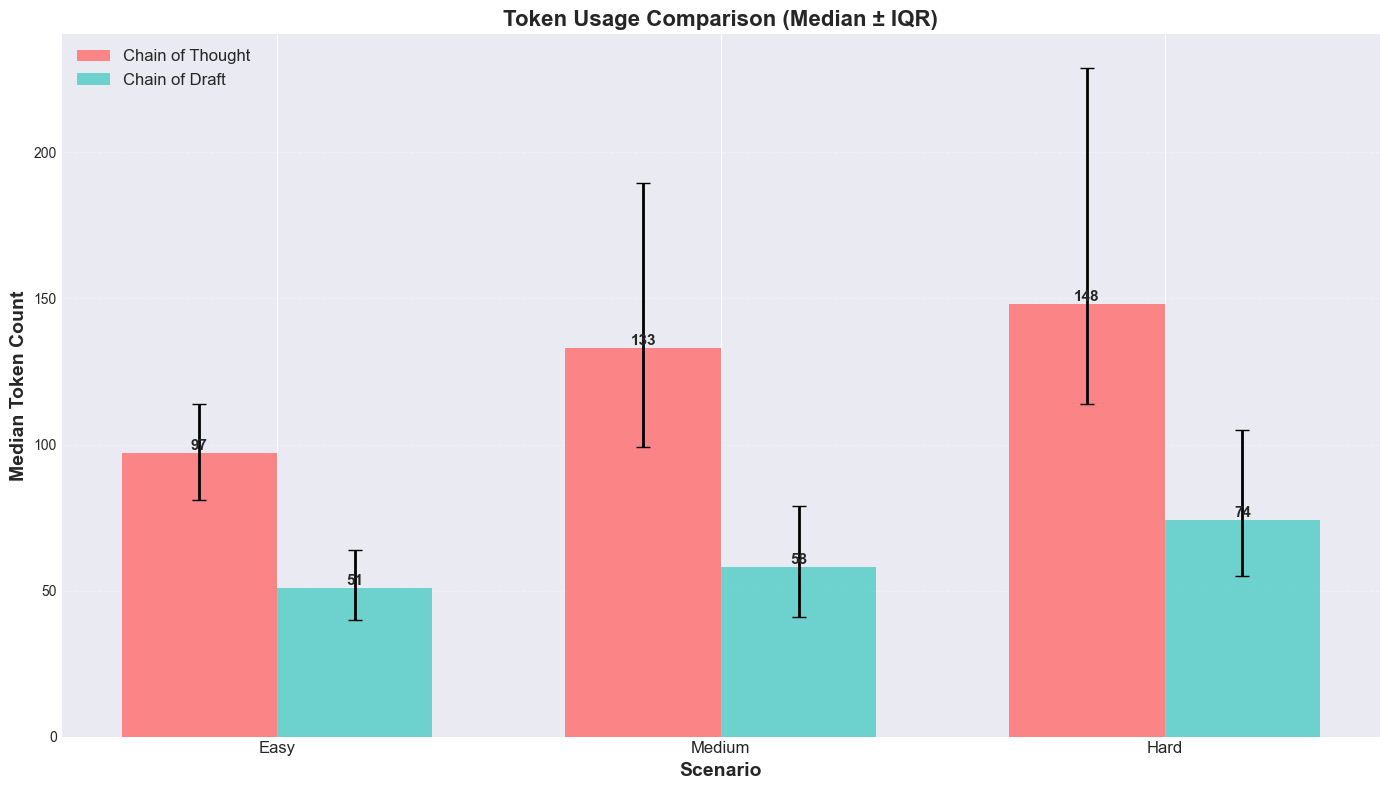


TOKEN COMPARISON SUMMARY (Median ± IQR)
Scenario     | CoT Median      | CoD Median      | Reduction
--------------------------------------------------------------------------------
Easy         |   97.0 [81-114] |   51.0 [40-64] |   47.4%
Medium       |  133.0 [99-190] |   58.0 [41-79] |   56.4%
Hard         |  148.0 [114-229] |   74.0 [55-105] |   50.0%


In [ ]:
# ============================================================================
# VISUALIZATION 1: Token Count Comparison with Quartiles
# ============================================================================

def plot_token_comparison_with_quartiles():
    """
    Bar chart showing median token counts with quartile ranges.
    Error bars show Q1-Q3 range (IQR).
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    
    scenario_names = [s.capitalize() for s in scenarios]
    x = np.arange(len(scenario_names))
    width = 0.35
    
    # Collect data
    cot_medians = []
    cot_q1 = []
    cot_q3 = []
    cod_medians = []
    cod_q1 = []
    cod_q3 = []
    
    for scenario in scenarios:
        if 'cot' not in all_metrics[scenario] or 'cod' not in all_metrics[scenario]:
            continue
        
        cot = all_metrics[scenario]['cot']
        cod = all_metrics[scenario]['cod']
        
        cot_medians.append(cot['median_tokens'])
        cot_q1.append(cot['q1_tokens'])
        cot_q3.append(cot['q3_tokens'])
        
        cod_medians.append(cod['median_tokens'])
        cod_q1.append(cod['q1_tokens'])
        cod_q3.append(cod['q3_tokens'])
    
    # Calculate error bars (distance from median to Q1/Q3)
    cot_err_lower = [med - q1 for med, q1 in zip(cot_medians, cot_q1)]
    cot_err_upper = [q3 - med for med, q3 in zip(cot_medians, cot_q3)]
    cod_err_lower = [med - q1 for med, q1 in zip(cod_medians, cod_q1)]
    cod_err_upper = [q3 - med for med, q3 in zip(cod_medians, cod_q3)]
    
    # Create bars with error bars
    bars1 = ax.bar(x - width/2, cot_medians, width, 
                   yerr=[cot_err_lower, cot_err_upper],
                   label='Chain of Thought', 
                   color='#FF6B6B', alpha=0.8,
                   capsize=5, error_kw={'linewidth': 2})
    
    bars2 = ax.bar(x + width/2, cod_medians, width,
                   yerr=[cod_err_lower, cod_err_upper],
                   label='Chain of Draft',
                   color='#4ECDC4', alpha=0.8,
                   capsize=5, error_kw={'linewidth': 2})
    
    ax.set_xlabel('Scenario', fontsize=14, fontweight='bold')
    ax.set_ylabel('Median Token Count', fontsize=14, fontweight='bold')
    ax.set_title('Token Usage Comparison (Median ± IQR)', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(scenario_names, fontsize=12)
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add median value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('images/token_comparison_quartiles.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\n" + "="*80)
    print("TOKEN COMPARISON SUMMARY (Median ± IQR)")
    print("="*80)
    print(f"{'Scenario':<12} | {'CoT Median':<15} | {'CoD Median':<15} | {'Reduction'}")
    print("-"*80)
    for i, scenario in enumerate(scenario_names):
        cot_med = cot_medians[i]
        cod_med = cod_medians[i]
        reduction = ((cot_med - cod_med) / cot_med) * 100
        print(f"{scenario:<12} | {cot_med:>6.1f} [{cot_q1[i]:.0f}-{cot_q3[i]:.0f}] | "
              f"{cod_med:>6.1f} [{cod_q1[i]:.0f}-{cod_q3[i]:.0f}] | {reduction:>6.1f}%")
    print("="*80)

plot_token_comparison_with_quartiles()

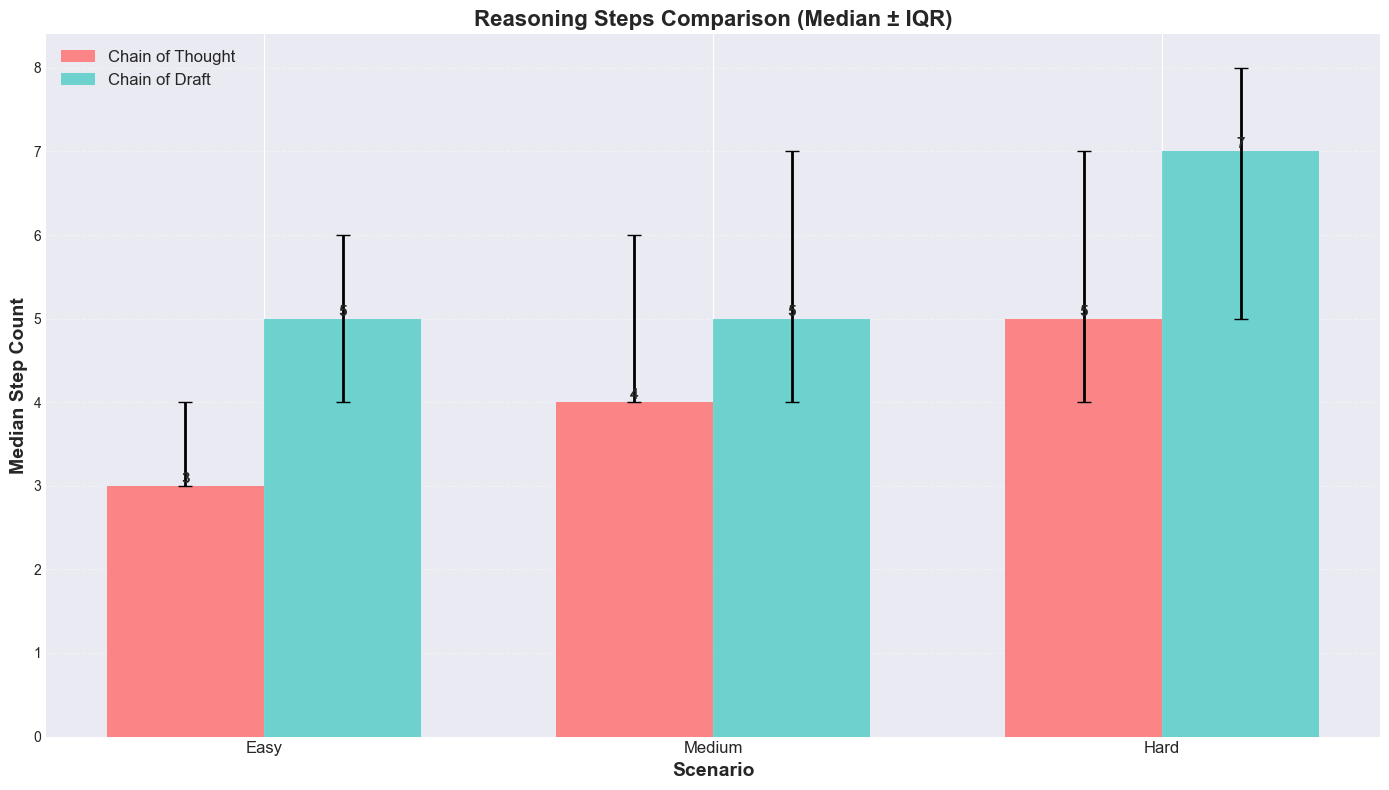


STEP COUNT SUMMARY (Median ± IQR)
Scenario     | CoT Median      | CoD Median      | Reduction
--------------------------------------------------------------------------------
Easy         |    3.0 [3-4] |    5.0 [4-6] |  -66.7%
Medium       |    4.0 [4-6] |    5.0 [4-7] |  -25.0%
Hard         |    5.0 [4-7] |    7.0 [5-8] |  -40.0%


In [ ]:
# ============================================================================
# VISUALIZATION 2: Step Count Comparison with Quartiles
# ============================================================================

def plot_step_comparison_with_quartiles():
    """
    Bar chart showing median step counts with quartile ranges.
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    
    scenario_names = [s.capitalize() for s in scenarios]
    x = np.arange(len(scenario_names))
    width = 0.35
    
    # Collect data
    cot_medians = []
    cot_q1 = []
    cot_q3 = []
    cod_medians = []
    cod_q1 = []
    cod_q3 = []
    
    for scenario in scenarios:
        if 'cot' not in all_metrics[scenario] or 'cod' not in all_metrics[scenario]:
            continue
        
        cot = all_metrics[scenario]['cot']
        cod = all_metrics[scenario]['cod']
        
        cot_medians.append(cot['median_steps'])
        cot_q1.append(cot['q1_steps'])
        cot_q3.append(cot['q3_steps'])
        
        cod_medians.append(cod['median_steps'])
        cod_q1.append(cod['q1_steps'])
        cod_q3.append(cod['q3_steps'])
    
    # Calculate error bars
    cot_err_lower = [med - q1 for med, q1 in zip(cot_medians, cot_q1)]
    cot_err_upper = [q3 - med for med, q3 in zip(cot_medians, cot_q3)]
    cod_err_lower = [med - q1 for med, q1 in zip(cod_medians, cod_q1)]
    cod_err_upper = [q3 - med for med, q3 in zip(cod_medians, cod_q3)]
    
    # Create bars
    bars1 = ax.bar(x - width/2, cot_medians, width, 
                   yerr=[cot_err_lower, cot_err_upper],
                   label='Chain of Thought', 
                   color='#FF6B6B', alpha=0.8,
                   capsize=5, error_kw={'linewidth': 2})
    
    bars2 = ax.bar(x + width/2, cod_medians, width,
                   yerr=[cod_err_lower, cod_err_upper],
                   label='Chain of Draft',
                   color='#4ECDC4', alpha=0.8,
                   capsize=5, error_kw={'linewidth': 2})
    
    ax.set_xlabel('Scenario', fontsize=14, fontweight='bold')
    ax.set_ylabel('Median Step Count', fontsize=14, fontweight='bold')
    ax.set_title('Reasoning Steps Comparison (Median ± IQR)', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(scenario_names, fontsize=12)
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('images/step_comparison_quartiles.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\n" + "="*80)
    print("STEP COUNT SUMMARY (Median ± IQR)")
    print("="*80)
    print(f"{'Scenario':<12} | {'CoT Median':<15} | {'CoD Median':<15} | {'Reduction'}")
    print("-"*80)
    for i, scenario in enumerate(scenario_names):
        cot_med = cot_medians[i]
        cod_med = cod_medians[i]
        reduction = ((cot_med - cod_med) / cot_med) * 100
        print(f"{scenario:<12} | {cot_med:>6.1f} [{cot_q1[i]:.0f}-{cot_q3[i]:.0f}] | "
              f"{cod_med:>6.1f} [{cod_q1[i]:.0f}-{cod_q3[i]:.0f}] | {reduction:>6.1f}%")
    print("="*80)

plot_step_comparison_with_quartiles()

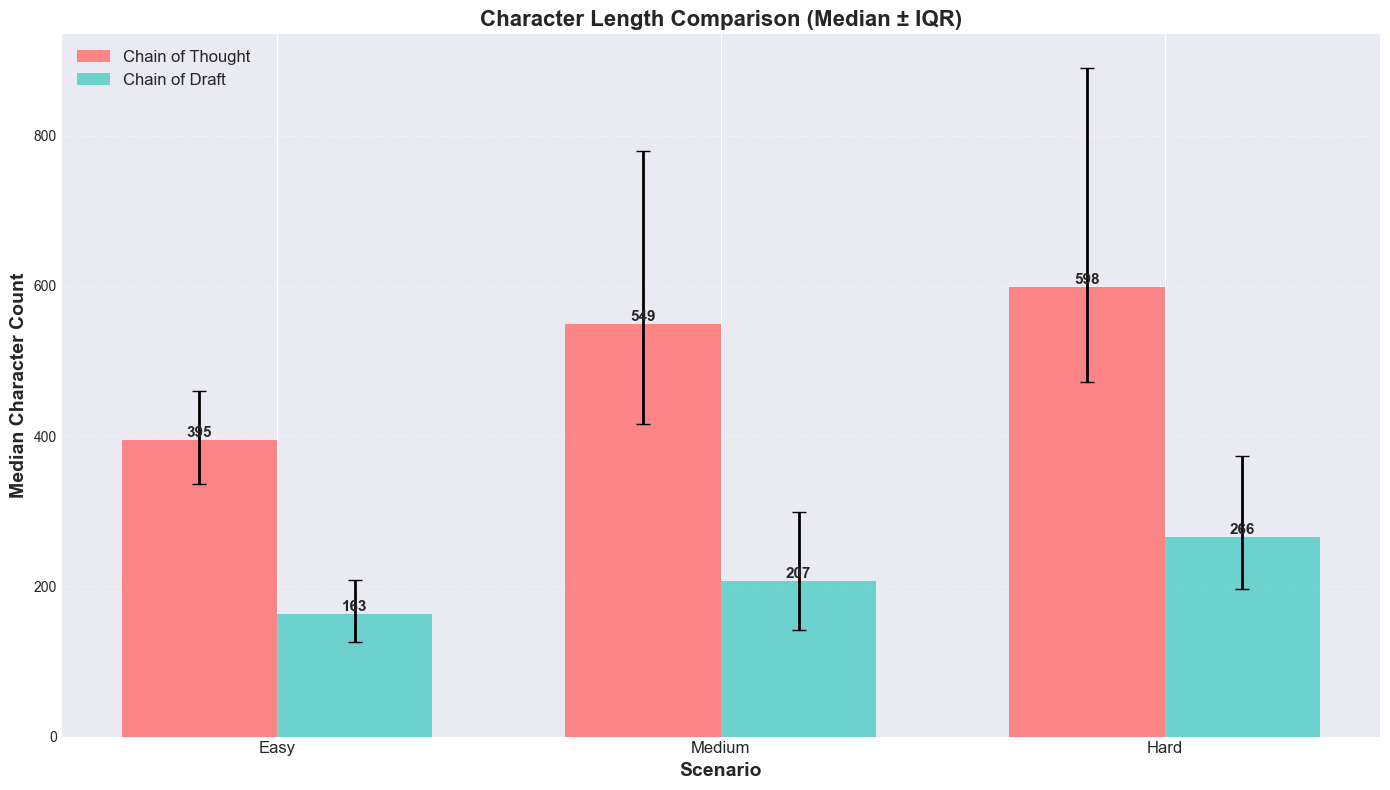

In [ ]:
# ============================================================================
# VISUALIZATION 3: Character Count Comparison with Quartiles
# ============================================================================

def plot_char_comparison_with_quartiles():
    """
    Bar chart showing median character counts with quartile ranges.
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    
    scenario_names = [s.capitalize() for s in scenarios]
    x = np.arange(len(scenario_names))
    width = 0.35
    
    # Collect data
    cot_medians = []
    cot_q1 = []
    cot_q3 = []
    cod_medians = []
    cod_q1 = []
    cod_q3 = []
    
    for scenario in scenarios:
        if 'cot' not in all_metrics[scenario] or 'cod' not in all_metrics[scenario]:
            continue
        
        cot = all_metrics[scenario]['cot']
        cod = all_metrics[scenario]['cod']
        
        cot_medians.append(cot['median_chars'])
        cot_q1.append(cot['q1_chars'])
        cot_q3.append(cot['q3_chars'])
        
        cod_medians.append(cod['median_chars'])
        cod_q1.append(cod['q1_chars'])
        cod_q3.append(cod['q3_chars'])
    
    # Calculate error bars
    cot_err_lower = [med - q1 for med, q1 in zip(cot_medians, cot_q1)]
    cot_err_upper = [q3 - med for med, q3 in zip(cot_medians, cot_q3)]
    cod_err_lower = [med - q1 for med, q1 in zip(cod_medians, cod_q1)]
    cod_err_upper = [q3 - med for med, q3 in zip(cod_medians, cod_q3)]
    
    # Create bars
    bars1 = ax.bar(x - width/2, cot_medians, width, 
                   yerr=[cot_err_lower, cot_err_upper],
                   label='Chain of Thought', 
                   color='#FF6B6B', alpha=0.8,
                   capsize=5, error_kw={'linewidth': 2})
    
    bars2 = ax.bar(x + width/2, cod_medians, width,
                   yerr=[cod_err_lower, cod_err_upper],
                   label='Chain of Draft',
                   color='#4ECDC4', alpha=0.8,
                   capsize=5, error_kw={'linewidth': 2})
    
    ax.set_xlabel('Scenario', fontsize=14, fontweight='bold')
    ax.set_ylabel('Median Character Count', fontsize=14, fontweight='bold')
    ax.set_title('Character Length Comparison (Median ± IQR)', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(scenario_names, fontsize=12)
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('images/char_comparison_quartiles.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_char_comparison_with_quartiles()

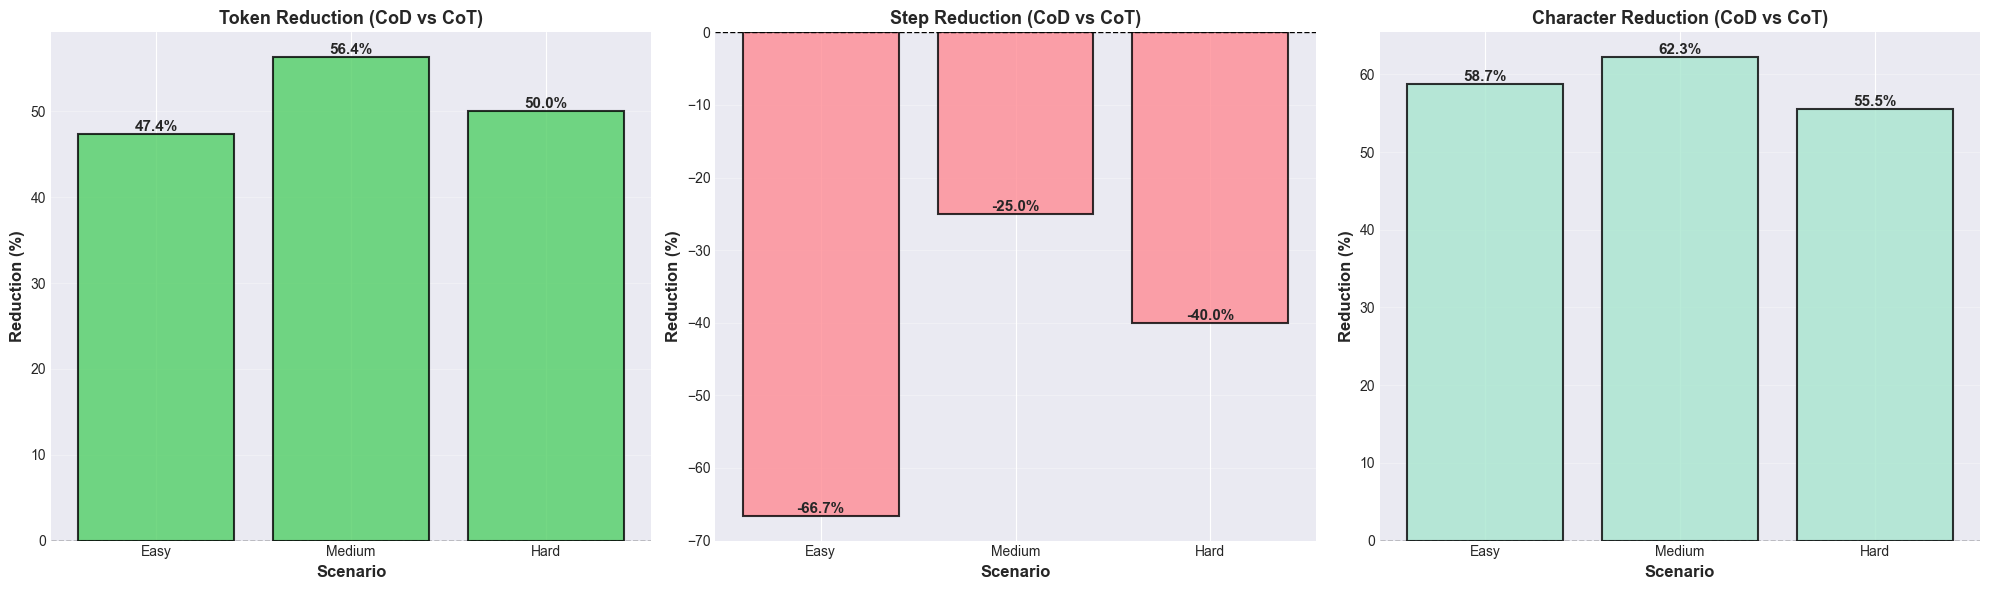


AGGREGATE REDUCTION STATISTICS
Mean Token Reduction:     51.3% ± 3.8%
Mean Step Reduction:      -43.9% ± 17.2%
Mean Character Reduction: 58.8% ± 2.8%


In [ ]:
# ============================================================================
# VISUALIZATION 4: Reduction Percentages
# ============================================================================

def plot_reduction_percentages():
    """
    Bar chart showing percentage reduction across all metrics.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    scenario_names = [s.capitalize() for s in scenarios]
    x = np.arange(len(scenario_names))
    
    # Calculate reductions
    token_reductions = []
    step_reductions = []
    char_reductions = []
    
    for scenario in scenarios:
        if 'cot' not in all_metrics[scenario] or 'cod' not in all_metrics[scenario]:
            continue
        
        cot = all_metrics[scenario]['cot']
        cod = all_metrics[scenario]['cod']
        
        token_red = ((cot['median_tokens'] - cod['median_tokens']) / cot['median_tokens']) * 100
        step_red = ((cot['median_steps'] - cod['median_steps']) / cot['median_steps']) * 100
        char_red = ((cot['median_chars'] - cod['median_chars']) / cot['median_chars']) * 100
        
        token_reductions.append(token_red)
        step_reductions.append(step_red)
        char_reductions.append(char_red)
    
    # Plot token reduction
    bars1 = ax1.bar(x, token_reductions, color='#51CF66', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Scenario', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Reduction (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Token Reduction (CoD vs CoT)', fontsize=13, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(scenario_names)
    ax1.grid(axis='y', alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    for bar, val in zip(bars1, token_reductions):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Plot step reduction
    bars2 = ax2.bar(x, step_reductions, color='#FF8B94', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Scenario', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Reduction (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Step Reduction (CoD vs CoT)', fontsize=13, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(scenario_names)
    ax2.grid(axis='y', alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    for bar, val in zip(bars2, step_reductions):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Plot character reduction
    bars3 = ax3.bar(x, char_reductions, color='#A8E6CF', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax3.set_xlabel('Scenario', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Reduction (%)', fontsize=12, fontweight='bold')
    ax3.set_title('Character Reduction (CoD vs CoT)', fontsize=13, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(scenario_names)
    ax3.grid(axis='y', alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    for bar, val in zip(bars3, char_reductions):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('images/reduction_percentages.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print aggregate
    print("\n" + "="*70)
    print("AGGREGATE REDUCTION STATISTICS")
    print("="*70)
    print(f"Mean Token Reduction:     {np.mean(token_reductions):.1f}% ± {np.std(token_reductions):.1f}%")
    print(f"Mean Step Reduction:      {np.mean(step_reductions):.1f}% ± {np.std(step_reductions):.1f}%")
    print(f"Mean Character Reduction: {np.mean(char_reductions):.1f}% ± {np.std(char_reductions):.1f}%")
    print("="*70)

plot_reduction_percentages()